## Instance Segmentation Using Habitat-Sim and Mask-R-CNN

author: Michael Piseno (mpiseno@fb.com)

This notebook will demonstrate how to set up an efficient datapipline for the purpose of instance segmentation using PyTorch, Mask-R-CNN, and Habitat-Sim as a data generator.

Other resources:
* [Mask-R-CNN paper](https://arxiv.org/pdf/1703.06870.pdf)
* [PyTorch instance segmentation tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [6]:
import os
import time
import math
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset

from habitat_sim.utils.data.dataextractor import ImageExtractor

### Data preparation and proprocessing

Below we will define the data extraction and preprocessing steps. Habitat-Sim's image data extraction API will be used to gather images from within the simulator for use inside a PyTorch Dataset subclass, which is subsequently fed into a PyTorch dataloader.

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))
    
    
class HabitatDataset(Dataset):
    def __init__(self, extractor, transform=None):
        self.extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.extractor)
    
    def __getitem__(self, idx):
        sample = self.extractor[idx]
        img, mask = sample["rgb"][:, :, :3], sample["semantic"]
        H, W = mask.shape
        
        obj_ids = np.unique(mask)
        masks = np.array([mask == obj_id for obj_id in obj_ids])
        labels = [obj_id for obj_id in obj_ids]
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            
            # Avoid zero area boxes
            if xmin == xmax:
                xmin = max(0, xmin - 1)
                xmax = min(W, xmax + 1)
            if ymin == ymax:
                ymin = max(0, ymin - 1)
                ymax = min(H, ymax + 1)
            
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        #labels = torch.as_tensor(labels, dtype=torch.int64)
        labels = torch.ones((len(masks),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        
        if self.transform:
            img = self.transform(img)
        
        return img, target
    

try:
    extractor.close()
except:
    pass

 
scene = "/private/home/mpiseno/Documents/Habitat/data/scene1/17DRP5sb8fy.glb"

#scene = "/private/home/mpiseno/Documents/Habitat/data/" # Replace with your scene directory
extractor = ImageExtractor(scene, output=["rgb", "semantic"], shuffle=False)


I0206 17:51:48.370782 2732 simulator.py:131] Loaded navmesh /private/home/mpiseno/Documents/Habitat/data/scene1/17DRP5sb8fy.navmesh


sim_cfg.physics_config_file = ./data/default.phys_scene_config.json
sim_cfg.physics_config_file = ./data/default.phys_scene_config.json


First we instantiate an ImageExtractor from Habitat-Sim. This requires that we previde a the filepath to a scene from which we will extract images. Optionally, we can specify the type of output we would like from the extractor. The default is just RGB images.

```python
scene_filepath = "../../data/scene_datasets/habitat-test-scenes/skokloster-castle.glb"
extractor = ImageExtractor(scene_filepath, output=["rgb", "semantic"])
```

We then create a custom class that subclasses PyTorch's dataset and override the __len__ and __getitem__ methods. Mask-R-CNN requires that we provide the image, bounding boxes, semantic masks, and class labels for each example, so we have implemented functionality for that in the __getitem__ method.

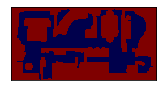

In [15]:
extractor.pose_extractor._show_topdown_view(show_valid_points=False)

In [20]:
# Specify which transforms to apply to the data in preprocessing
transform = T.Compose([
    T.ToTensor()
])

dataset_train = HabitatDataset(extractor, transform=transform)
dataset_test = HabitatDataset(extractor, transform=transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=False,
                                          collate_fn=collate_fn)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=False,
                                          collate_fn=collate_fn)

In [ ]:
# print(len(extractor))

# for idx in range(len(extractor)):
#     sample = extractor[idx]
#     plt.imshow(sample['rgb'])
#     plt.show()

Num masks: 12


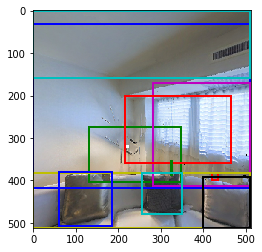

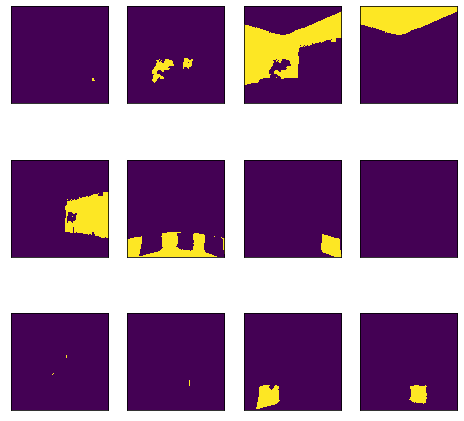

In [10]:
import matplotlib.patches as patches


def show_data(data_idx, mask_idx=0, show_masks=False):
    img, target = dataset_train[data_idx]
    idx = mask_idx

    print(f'Num masks: {len(target["masks"])}')
    img = img.permute(1, 2, 0).numpy()
    masks = target['masks'].numpy()
    boxes = target['boxes'].numpy()
    label = target['labels'][mask_idx]
    area = target['area'][mask_idx]
    fig ,ax = plt.subplots(1)
    ax.imshow(img)
    cmap = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'w'}
    for i, box in enumerate(boxes):
        h, w = box[3] - box[1], box[2] - box[0]
        rect = patches.Rectangle((box[0], box[1]) , w, h, linewidth=2,
                                 edgecolor=cmap[i % len(cmap)], facecolor='none')
        ax.add_patch(rect)

    if show_masks:
        plt.show()
        fig=plt.figure(figsize=(8, 8))
        columns = 4
        rows = math.ceil(len(target['masks']) / columns)
        for i in range(1, columns * rows + 1):
            if i > len(target['masks']):
                break
            mask = masks[i - 1]
            fig.add_subplot(rows, columns, i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask)

        plt.show()
        
show_data(1, show_masks=True)

Num masks: 31


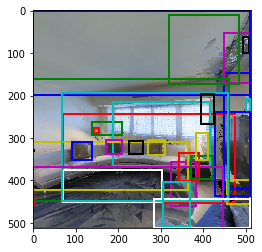

In [9]:
show_data(9)

### Model and Training Setup

In [21]:
# Credit: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


num_epochs = 100
num_classes = 40 # 40 object categories in matterport3d paper https://arxiv.org/pdf/1709.06158.pdf
model_weights = "maskrcnn-weights"
load_weights = True

model = build_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


### Training and Evaluation

In [22]:
# Example of training
from examples.instance_segmentation.engine import train_one_epoch
import examples.instance_segmentation.utils


if load_weights:
    # Load model weights
    pass

# We have to explicitly set the extractor mode because there can only be one instance of an extractor at a time,
# so the dataset_train and dataset_test must share the same extractor
extractor.set_mode('train')

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=10)
    lr_scheduler.step()
    
    if epoch % 100 == 0:
        # Save model weights
        pass

# import math

# for i, batch in enumerate(data_loader):
#     images, targets = batch
#     images = list(image.to(device) for image in images)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
#     loss_dict = model(images, targets)
#     losses = sum(loss for loss in loss_dict.values())
#     print(loss_dict)
#     print(str(losses.item()) + "\n")
    
#     if not math.isfinite(losses):
#         print(f'not finite loss: {i}')
#         break
    
    

Epoch: [0]  [0/8]  eta: 0:01:02  lr: 0.000719  loss: 9.7157 (9.7157)  loss_classifier: 3.3884 (3.3884)  loss_box_reg: 0.5174 (0.5174)  loss_mask: 1.1267 (1.1267)  loss_objectness: 3.0232 (3.0232)  loss_rpn_box_reg: 1.6599 (1.6599)  time: 7.7704  data: 0.0484
Epoch: [0]  [7/8]  eta: 0:00:07  lr: 0.005000  loss: 4.7689 (6.0086)  loss_classifier: 1.5149 (2.0448)  loss_box_reg: 0.4804 (0.4588)  loss_mask: 0.8123 (0.9366)  loss_objectness: 0.7373 (1.4990)  loss_rpn_box_reg: 0.9162 (1.0694)  time: 7.6480  data: 0.0959
Epoch: [0] Total time: 0:01:01 (7.6487 s / it)
Epoch: [1]  [0/8]  eta: 0:00:49  lr: 0.005000  loss: 3.6566 (3.6566)  loss_classifier: 0.3878 (0.3878)  loss_box_reg: 0.2536 (0.2536)  loss_mask: 0.7794 (0.7794)  loss_objectness: 0.7582 (0.7582)  loss_rpn_box_reg: 1.4776 (1.4776)  time: 6.1990  data: 0.0605


KeyboardInterrupt: 